# `Baseline` решения

## импорт `YOLO`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [3]:
import matplotlib.pyplot as plt
import cv2

In [4]:
# !pip3 install -U ultralytics --user

In [5]:
import ultralytics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/a8/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
from ultralytics import settings
settings.update({"wandb": False, "tensorboard": False, "clearml":False, "mlflow":False, "neptune":False, 'comet': False, 'dvc': False, 'hub': False })

In [7]:
print(settings)

JSONDict("/home/a8/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "b7c64c30092389f0661537eedcc78e65007bb645b8eb07ebe1647a62a71a18db",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": false,
  "comet": false,
  "dvc": false,
  "hub": false,
  "mlflow": false,
  "neptune": false,
  "raytune": true,
  "tensorboard": false,
  "wandb": false,
  "vscode_msg": true
}


Также `ultralytics` предоставляют собственный интерфейс проверки вычислителей.

In [8]:
ultralytics.checks()

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (Tesla M40 24GB, 22933MiB)
Setup complete ✅ (72 CPUs, 125.8 GB RAM, 75.2/233.2 GB disk)


In [9]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

In [10]:
model.info()

YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

## Импорты

In [11]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [12]:
from urllib.request import urlretrieve
from torchvision.datasets.utils import download_and_extract_archive

## Пути к набору данных

### путь к набору данных

In [16]:
root_path = Path(os.getcwd()) 
print(list(root_path.iterdir()))

[PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/.ipynb_checkpoints'), PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters'), PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters_task.zip'), PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/data.yaml'), PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/test_best.pt'), PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/yolov8n.pt'), PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/vertopal.com_Craters_Project_baseline_and_task (1).docx'), PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/Craters_Project_baseline_and_task.ipynb')]


In [17]:
dataset_path = root_path / 'craters' #'LU3M6TGT_yolo_format'
print(list(dataset_path.iterdir()))

[PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/test'), PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/train'), PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/valid')]


### путь к тренировочной и к валидационной части

In [18]:
ext = 'jpg' #'png'

In [19]:
images_path = dataset_path / 'train' / 'images'
labels_path = dataset_path / 'train' / 'labels'

labels_path = list(labels_path.glob('**/*.txt'))
images_path = list(images_path.glob(f'**/*.{ext}'))


In [20]:
val_image_path  = dataset_path / 'valid' / 'images'
val_labels_path = dataset_path / 'valid' / 'labels'

val_labels_path = list(val_labels_path.glob('**/*.txt'))
val_image_path  = list(val_image_path.glob(f'**/*.{ext}'))



In [21]:
test_images_path = dataset_path / 'test' / 'images'

test_images_path = list(test_images_path.glob(f'**/*.{ext}'))

In [22]:
test_images_path[1]

PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/test/images/mars_crater--12-_jpg.rf.26060e7ca4ca8781bcaf011b9b70b7db.jpg')

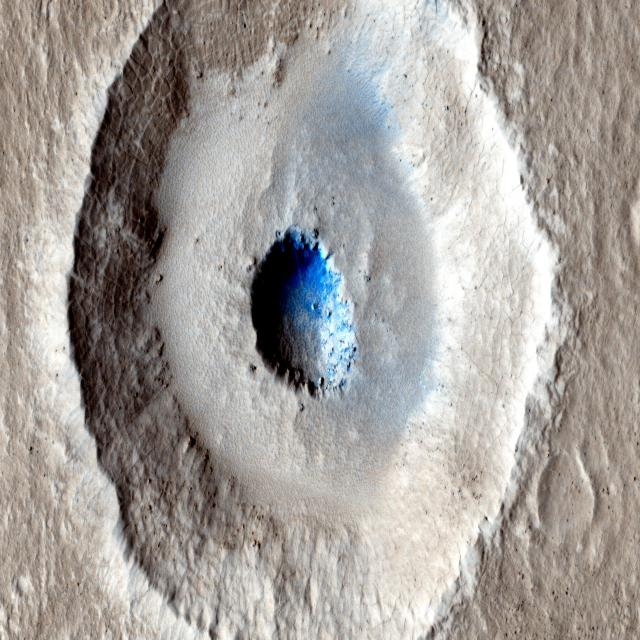

In [23]:
Image.open(images_path[1])

### описание набора данных

In [24]:
data_yaml = dataset_path  / 'data.yaml'
data_yaml

PosixPath('/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/data.yaml')

In [25]:
import yaml

data = {
    f'train': str(dataset_path / 'train' / 'images'),
    f'val': str(dataset_path / 'valid' / 'images'),
    'nc': 1,
    'names': ['0']
}

with open(data_yaml, 'w') as file:
    yaml.safe_dump(data, file)

print("New YAML file created successfully.")

with open(data_yaml, 'r') as file:
    data=yaml.safe_load( file)
print(data)

New YAML file created successfully.
{'names': ['0'], 'nc': 1, 'train': '/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/train/images', 'val': '/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/valid/images'}


## Построение примеров данных

In [26]:
def yolo2coco(xc, yc, w, h, image_width, image_height):
    xc, w = xc*image_width,  w*image_width
    yc, h = yc*image_height, h*image_height
    xmin = xc - w//2
    ymin = yc - h//2
    return xmin,ymin,w, h

def plot_bbox(image_pth, ann_pth = None, predicted_boxes = None, pred_classes = None):
    image =  np.asarray(Image.open(image_pth))
    height, width = image.shape[:2]

    if ann_pth == None:
        ann_name = image_pth.parts[-1][:-4]+'.txt'
        ann_pth = Path(*image_pth.parts[:-2]) / 'labels'/ann_name
    data = pd.read_csv(ann_pth, sep=" ", header=None).values     
    
    bbox   = np.asarray(data)[:,1:5]
    
    fig, axs = plt.subplots(1, 2, figsize = (8,4))
    image_ = np.copy(image).astype(float)/image.max()
    
    # Ground Truth    
    axs[0].imshow(np.clip(image_,0,1), 'gray')
    axs[0].axis('off'); axs[0].set_title('Original Image')
    #----------------------------
    
    # Object Detection BBoxes
    axs[1].imshow(np.clip(image_,0,1), 'gray')
    
    for box in bbox:
        xmin,ymin,w,h = yolo2coco(*box, width,height)
        bb = patches.Rectangle(xy     = (xmin,ymin), 
                               width  = w,height = h, 
                               linewidth=2, edgecolor="blue", facecolor="none")
        axs[1].add_patch(bb)  

    if predicted_boxes != None:
        if pred_classes == None:
            pred_classes = ['0']*len(predicted_boxes)
        for cls,box in zip(np.array(pred_classes),np.array(predicted_boxes)):
            xmin,ymin,w,h = yolo2coco(*box, width,height)
            bb = patches.Rectangle(xy     = (xmin,ymin), 
                                   width  = w,height = h, 
                                   linewidth=2, edgecolor="red", facecolor="none")
            axs[1].add_patch(bb)


            axs[1].text(xmin,ymin,str(cls),fontsize=10, color="green", weight="bold")
    
    axs[1].axis('off'); axs[1].set_title('Object Detection')
    plt.tight_layout()
    plt.show()

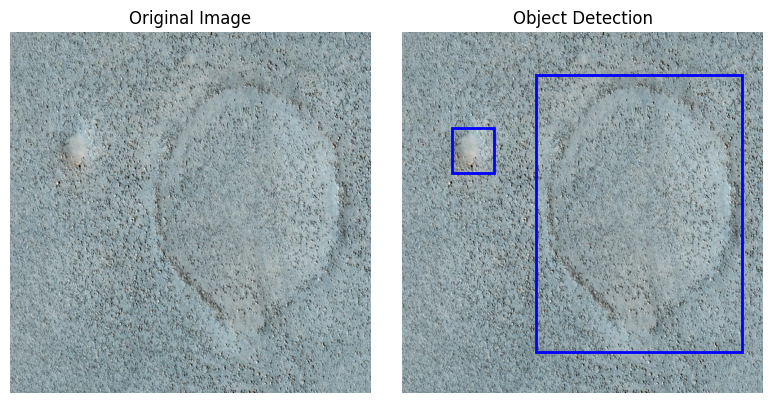

In [27]:
plot_bbox(images_path[47] )

## Проверка модели и построение результата

In [28]:
model = YOLO("yolov8n.pt")

results = model(images_path[47])


image 1/1 /wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/train/images/mars_crater--10-_jpg.rf.585b1aa305997e3055e86fcac72a806b.jpg: 640x640 (no detections), 9.1ms
Speed: 3.7ms preprocess, 9.1ms inference, 18.6ms postprocess per image at shape (1, 3, 640, 640)


In [29]:
def plot_result(result):
    image_pth = Path(result.path)
    image =  np.asarray(Image.open(image_pth))
    height, width = image.shape[:2]

    ann_name = image_pth.parts[-1][:-4]+'.txt'
    ann_pth = Path(*image_pth.parts[:-2]) / 'labels'/ann_name
    data = pd.read_csv(ann_pth, sep=" ", header=None).values     
    
    bbox   = np.asarray(data)[:,1:5]
    
    fig, axs = plt.subplots(1, 2, figsize = (8,4))
    image_ = np.copy(image).astype(float)/image.max()
    
    # Ground Truth    
    axs[0].imshow(np.clip(image_,0,1), 'gray')
    axs[0].axis('off'); axs[0].set_title('Original Image')
    #----------------------------
    
    # Object Detection BBoxes
    axs[1].imshow(np.clip(image_,0,1), 'gray')
    
    for box in bbox:
        xmin,ymin,w,h = yolo2coco(*box, width,height)
        bb = patches.Rectangle(xy     = (xmin,ymin), 
                               width  = w,height = h, 
                               linewidth=2, edgecolor="blue", facecolor="none")
        axs[1].add_patch(bb)  

    predicted_boxes = result.boxes.xywhn
    pred_classes = result.boxes.cls.long()
    if pred_classes == []:
        pred_classes = len(predicted_boxes)*['0']
    
    if predicted_boxes != None:
        if pred_classes == None:
            pred_classes = ['0']*len(predicted_boxes)
        
        for cls,box in zip(np.array(pred_classes),np.array(predicted_boxes)):
            xmin,ymin,w,h = yolo2coco(*box, width,height)
            bb = patches.Rectangle(xy     = (xmin,ymin), 
                                   width  = w,height = h, 
                                   linewidth=2, edgecolor="red", facecolor="none")
            axs[1].add_patch(bb)


            axs[1].text(xmin,ymin,str(cls),fontsize=10, color="green", weight="bold")
    
    axs[1].axis('off'); axs[1].set_title('Object Detection')
    plt.tight_layout()
    plt.show()

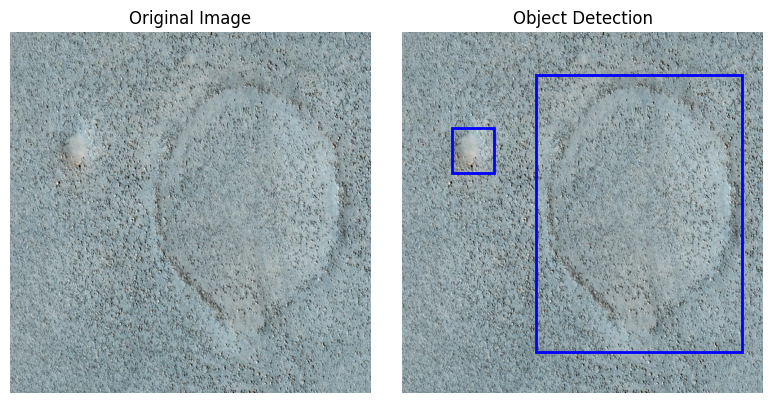

In [33]:
plot_result(results[0].cpu() )

## Тренировка модели

In [35]:
model = YOLO("yolov8n.pt")
results = model.train(data=data_yaml,imgsz=640, epochs = 12)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (Tesla M40 24GB, 22933MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/data.yaml, epochs=12, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop

train: Scanning /wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/train/labels.cache... 98 images, 9 backgrounds, 0 corrupt: 100%|██████████| 98/98 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/valid/labels.cache... 26 images, 2 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/12      2.37G      1.926      3.514      1.553          7        640: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         26        202    0.00962      0.371     0.0156     0.0065



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/12       2.4G      1.807      3.186      1.548          6        640: 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         26        202     0.0183      0.708     0.0724     0.0326


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/12      2.46G      1.787      3.163      1.336          2        640: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         26        202      0.021      0.812      0.176     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/12      2.47G      1.614      1.951      1.332         22        640: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         26        202     0.0229      0.886      0.119     0.0579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/12      2.47G      1.617      2.048      1.332         10        640: 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         26        202     0.0222      0.856      0.164     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/12       2.4G      1.575      1.706      1.291         12        640: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         26        202     0.0228      0.881      0.246      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/12      2.41G      1.564      1.912      1.223          5        640: 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         26        202     0.0218      0.842      0.142     0.0754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/12      2.41G      1.523      1.646      1.241         37        640: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         26        202      0.501      0.262      0.279      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/12      2.49G       1.47      1.502      1.258         13        640: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         26        202      0.844      0.129      0.477      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/12      2.45G      1.426      1.615      1.234          3        640: 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         26        202      0.802      0.109      0.467      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/12      2.41G      1.468      1.559      1.183         26        640: 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         26        202      0.763      0.163       0.48      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/12      2.41G      1.437      1.464      1.175         17        640: 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         26        202      0.821      0.296      0.574      0.342



12 epochs completed in 0.010 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (Tesla M40 24GB, 22933MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


                   all         26        202      0.822      0.297      0.574      0.343
Speed: 0.2ms preprocess, 3.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train2


## Проверка результата на валидации

### все результаты

In [36]:
results = model.val(data=data_yaml,imgsz=640)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (Tesla M40 24GB, 22933MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/valid/labels.cache... 26 images, 2 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


                   all         26        202      0.822      0.297      0.579      0.343
Speed: 0.3ms preprocess, 11.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train22


### Целевой результат

In [37]:
print(f'map 50:95 = {results.box.map:.3f}')  # map50-95

map 50:95 = 0.343


### Проверим что модель что то находит на тестовых данных

In [38]:
results = model(test_images_path[:], )


0: 640x640 (no detections), 4.0ms
1: 640x640 (no detections), 4.0ms
2: 640x640 1 0, 4.0ms
3: 640x640 1 0, 4.0ms
4: 640x640 (no detections), 4.0ms
5: 640x640 2 0s, 4.0ms
6: 640x640 (no detections), 4.0ms
7: 640x640 1 0, 4.0ms
8: 640x640 (no detections), 4.0ms
9: 640x640 (no detections), 4.0ms
10: 640x640 (no detections), 4.0ms
11: 640x640 (no detections), 4.0ms
12: 640x640 (no detections), 4.0ms
13: 640x640 1 0, 4.0ms
14: 640x640 2 0s, 4.0ms
15: 640x640 (no detections), 4.0ms
16: 640x640 (no detections), 4.0ms
17: 640x640 (no detections), 4.0ms
18: 640x640 (no detections), 4.0ms
Speed: 1.7ms preprocess, 4.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Результаты модели можно проверить "на глаз" при желании.

## Как найти обученную модель для подачи на проверку.

* Модель можно найти в описании тренировки - параметр `save_dir` например в виде `=runs\detect\train9`
* Также можно поменять директорию для сохранения модели как `settings.update({'runs_dir': '/path/to/runs'})`
* В директории как правило будут два файла `last.pt` и `best.pt`. Нужен  `best.pt`.
* Файл `best.pt` нужно сохранить под своим именем и сдать.
* Проверить модель можно так, как это показано ниже.
* Отметим, что загруженную модель также можно дообучить при желании.

Также отметим что путь к обученной модели можно получить следующим образом:

In [39]:
save_dir = model.trainer.save_dir 
best_trained_weights = save_dir / 'weights' / 'best.pt'
best_trained_weights

PosixPath('runs/detect/train2/weights/best.pt')

In [40]:
model = YOLO(best_trained_weights)  # load a partially trained model
# results = model.train(data=data_yaml,imgsz=640, epochs = 7)
results = model.val(data=data_yaml,imgsz=640)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (Tesla M40 24GB, 22933MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /wdata/Computer_Vision_T3/Kaggle_objects/proj/student/craters/valid/labels.cache... 26 images, 2 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


                   all         26        202      0.822      0.297      0.579      0.343
Speed: 1.1ms preprocess, 4.4ms inference, 0.0ms loss, 8.1ms postprocess per image
Results saved to runs/detect/val


# Задание на итоговый проект

__Цель__ - обучить нейронную сеть типа `YOLO` для решения проблемы поиска и определения краторов на изобажениях лунохода.

Действия:
1. Прочитать пример работы с набором данных.
2. Обучить модель детекции краторов, используюя целевую метрику `map50:95`
3. Выгрузить обученную модель (файл `best.pt`).
4. Переименовать модель в соответствии с фио на Английском языке и сдать ее.
5. Модель должна дать на тестовой части набора данных точность не ниже 40%. В противном случае баллы будут снижены в двое.
6. На решение задачи дается 2 попытки